Demand Predict

Basic Data Preparation

In [1]:
from pandas import read_csv
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [9]:
dataset = read_csv('~/work/DemandPrediction/2016demand2017.csv')

In [10]:
# manually specify column names
dataset.columns = ['date', 'quantity']
dataset.index.name = 'date'
dataset.head(5)

,date,quantity
date,,
0,2016-01-01,3
1,2016-01-02,2
2,2016-01-03,0
3,2016-01-04,2
4,2016-01-05,0


In [11]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

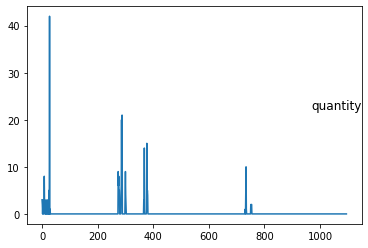

In [12]:

# plot each column
pyplot.figure()
pyplot.plot(values[:, 1])
pyplot.title(dataset.columns[1], y=0.5, loc='right')
pyplot.show()

Multivariate LSTM Forecast Model

LSTM Data Preparation:<br>
***framing the dataset as a supervised learning problem and normalizing the input variables.***

In [13]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [15]:
# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

In [16]:
values

array([[0, 3],
       [1, 2],
       [2, 0],
       ...,
       [1093, 0],
       [1094, 0],
       [1095, 0]], dtype=object)

In [17]:
# ensure all data is float
values = values.astype('float32')

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [19]:
num_lags = 30
num_features=1
# frame as supervised learning
reframed = series_to_supervised(scaled, num_lags, 1)

In [20]:
reframed.head(10)

,var1(t-30),var2(t-30),var1(t-29),var2(t-29),var1(t-28),var2(t-28),var1(t-27),var2(t-27),var1(t-26),var2(t-26),...,var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
30,0.000000,0.071429,0.000913,0.047619,0.001826,0.000000,0.002740,0.047619,0.003653,0.000000,...,0.023744,0.00000,0.024658,1.00000,0.025571,0.00000,0.026484,0.02381,0.027397,0.0
31,0.000913,0.047619,0.001826,0.000000,0.002740,0.047619,0.003653,0.000000,0.004566,0.071429,...,0.024658,1.00000,0.025571,0.00000,0.026484,0.02381,0.027397,0.00000,0.028311,0.0
32,0.001826,0.000000,0.002740,0.047619,0.003653,0.000000,0.004566,0.071429,0.005479,0.071429,...,0.025571,0.00000,0.026484,0.02381,0.027397,0.00000,0.028311,0.00000,0.029224,0.0
33,0.002740,0.047619,0.003653,0.000000,0.004566,0.071429,0.005479,0.071429,0.006393,0.000000,...,0.026484,0.02381,0.027397,0.00000,0.028311,0.00000,0.029224,0.00000,0.030137,0.0
34,0.003653,0.000000,0.004566,0.071429,0.005479,0.071429,0.006393,0.000000,0.007306,0.190476,...,0.027397,0.00000,0.028311,0.00000,0.029224,0.00000,0.030137,0.00000,0.031050,0.0
35,0.004566,0.071429,0.005479,0.071429,0.006393,0.000000,0.007306,0.190476,0.008219,0.047619,...,0.028311,0.00000,0.029224,0.00000,0.030137,0.00000,0.031050,0.00000,0.031963,0.0
36,0.005479,0.071429,0.006393,0.000000,0.007306,0.190476,0.008219,0.047619,0.009132,0.071429,...,0.029224,0.00000,0.030137,0.00000,0.031050,0.00000,0.031963,0.00000,0.032877,0.0
37,0.006393,0.000000,0.007306,0.190476,0.008219,0.047619,0.009132,0.071429,0.010046,0.000000,...,0.030137,0.00000,0.031050,0.00000,0.031963,0.00000,0.032877,0.00000,0.033790,0.0
38,0.007306,0.190476,0.008219,0.047619,0.009132,0.071429,0.010046,0.000000,0.010959,0.000000,...,0.031050,0.00000,0.031963,0.00000,0.032877,0.00000,0.033790,0.00000,0.034703,0.0
39,0.008219,0.047619,0.009132,0.071429,0.010046,0.000000,0.010959,0.000000,0.011872,0.047619,...,0.031963,0.00000,0.032877,0.00000,0.033790,0.00000,0.034703,0.00000,0.035616,0.0


In [21]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [22]:
values = reframed.values
values.shape

(1066, 62)

Define and Fit Model

In [23]:
import math
# split into train and test sets
values = reframed.values
n_train_day = math.floor(values.shape[0] *0.8)
#n_train_day = 20
train = values[:n_train_day,:]
test = values[n_train_day:, :]

In [24]:
# split into input and outputs
n_obs = num_lags * num_features
train_X, train_y = train[:, :n_obs], train[:, -num_features]
test_X, test_y = test[:, :n_obs], test[:, -num_features]
print(train_X.shape, len(train_X), train_y.shape)

(852, 30) 852 (852,)


In [25]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(852, 30) (852,) (214, 30) (214,)


In [26]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], num_lags, num_features))
test_X = test_X.reshape((test_X.shape[0], num_lags, num_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(852, 30, 1) (852,) (214, 30, 1) (214,)


In [27]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [28]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
12/12 - 0s - loss: 0.0103 - val_loss: 0.0134
Epoch 2/50
12/12 - 0s - loss: 0.0088 - val_loss: 6.9323e-04
Epoch 3/50
12/12 - 0s - loss: 0.0059 - val_loss: 0.0018
Epoch 4/50
12/12 - 0s - loss: 0.0106 - val_loss: 0.0091
Epoch 5/50
12/12 - 0s - loss: 0.0060 - val_loss: 0.0048
Epoch 6/50
12/12 - 0s - loss: 0.0118 - val_loss: 0.0105
Epoch 7/50
12/12 - 0s - loss: 0.0122 - val_loss: 0.0062
Epoch 8/50
12/12 - 0s - loss: 0.0070 - val_loss: 0.0026
Epoch 9/50
12/12 - 0s - loss: 0.0104 - val_loss: 0.0033
Epoch 10/50
12/12 - 0s - loss: 0.0101 - val_loss: 0.0096
Epoch 11/50
12/12 - 0s - loss: 0.0070 - val_loss: 0.0010
Epoch 12/50
12/12 - 0s - loss: 0.0139 - val_loss: 5.1765e-04
Epoch 13/50
12/12 - 0s - loss: 0.0068 - val_loss: 0.0028
Epoch 14/50
12/12 - 0s - loss: 0.0111 - val_loss: 0.0048
Epoch 15/50
12/12 - 0s - loss: 0.0160 - val_loss: 0.0103
Epoch 16/50
12/12 - 0s - loss: 0.0126 - val_loss: 0.0045
Epoch 17/50
12/12 - 0s - loss: 0.0066 - val_loss: 0.0033
Epoch 18/50
12/12 - 0s - loss: 0

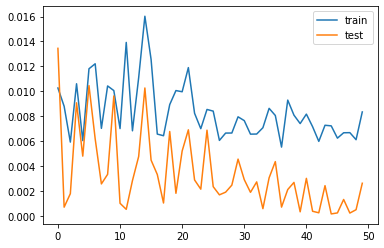

In [29]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evaluate Model

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], num_lags*num_features))

In [31]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
print(inv_yhat.shape)


(214, 2)


In [32]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [33]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [34]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.862


In [35]:
rmse = rmse* (1/100)

In [36]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.029


In [38]:
#save model
model.save("./model.h5")

In [40]:
from keras.models import load_model
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
